# Mục Đích
> Trong phần này chúng ta sẽ đi qua những kiến thức cơ bản và cách dự báo dữ liệu dạng time-series trước khi đi vào thực hành ML, DL, lý do là để chúng ta nắm được các kiến thức cơ bản cũng như hiểu được một số những phương pháp dùng mô hình toán học cơ bản trong time-series. Những phương pháp này có thể dược sử dụng làm baseline để so sánh với cách mô hình ML, DL.

> Các kiến thức trong phần này được thu lượm từ khóa học deeplearning specialization

In [ ]:
#default_exp tseries.basics

In [ ]:
#export
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence, timeseries_dataset_from_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#hide
# Kiểm tra GPU:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Các Loại time-series

## Xu Thế (Trend) và Tính Vụ Mùa (Seasonality)

Tạo hàm vẽ đồ thị:

In [ ]:
#export
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

### Xu Thế

In [ ]:
#export
# hàm tạo xu hướng: đơn giản là hàm của thời gian nhân với tỷ lệ slope (tanh):
def create_trend(times, slope=0):
    return times * slope

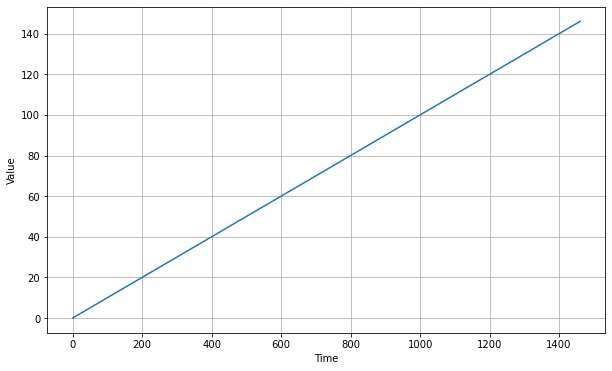

In [ ]:
#export
# Tạo time series và vẽ đồ thị giữa thời gian và giá trị:
times = np.arange(4*365 +1) # tạo dữ liệu cho 4 năm
tseries = create_trend(times, .1)
plot_series(times, tseries)

### Vụ Mùa

Ý tưởng: Vụ mùa mang tính lặp đi lặp lại theo từng thời kỳ, như vậy để tạo ra vụ mùa thì chúng ta cần xác định 2 thứ:
1. Thời kỳ: sau bao lâu thì hiện tượng lặp lại (giả sử thời kỳ mang tính chất theo từng năm)
2. Biến động thời kỳ: với từng thời kỳ, chúng ta muốn biến động gì xảy ra: đơn giản là tăng hoặc giảm hoặc xoắn quẩy...

Ở đây, mình sử dụng lại code của khóa học:

In [ ]:
#export
# Tạo xu tính chất vụ mùa:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# Tạo dữ liệu có vụ mùa:
def create_seasonalities(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

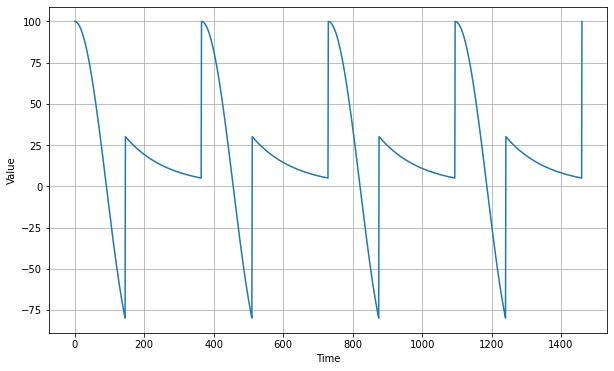

In [ ]:
#export
tseries = create_seasonalities(times, 365, amplitude=100)
plot_series(times, tseries)

### Kết hợp Xu Thế và Vụ Mùa

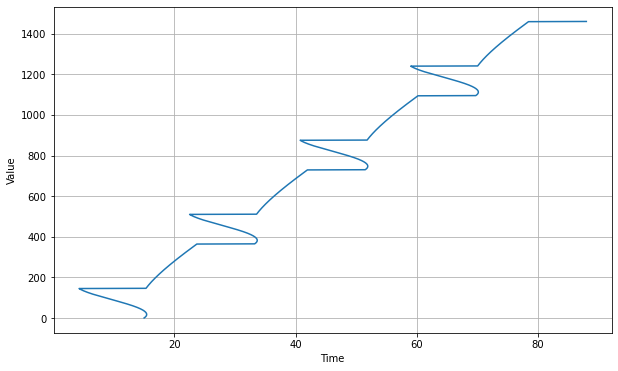

In [ ]:
#export
baseline = 5
tseries = baseline + create_trend(times, slope=.05) + create_seasonalities(times, period=365, amplitude=10)
plot_series(tseries, times)

## Nhiễu (Noise)
> Noise là hiện tượng phổ biến trong dữ liệu time-series, thể hiện sự biến động ngẫu nhiên không dự báo được, có mean = 0 và variance xác định. Khái niệm về nhiễu phổ biến nhất trong time-series chính là white-noise.

In [ ]:
#export
def create_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed) # tạo seed
    return rnd.randn(len(time)) * noise_level

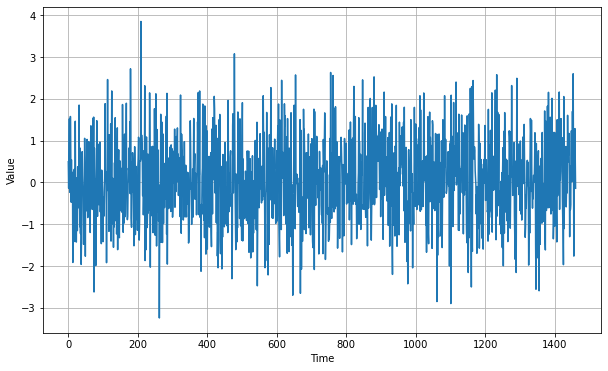

In [ ]:
#export
noises = create_noise(times, seed=42)
plot_series(times, noises)

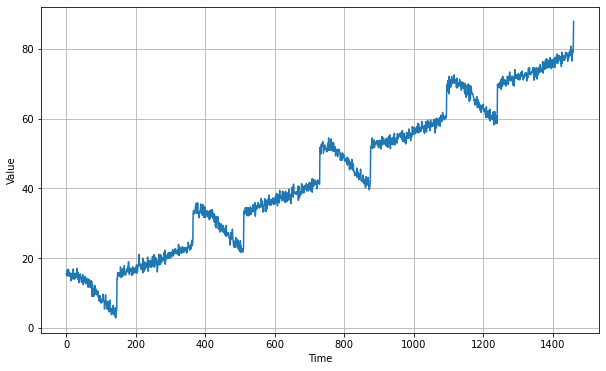

In [ ]:
#export
## Bổ sung noise vào:
tseries += noises
plot_series(times, tseries)

## Autocorrelation:
> Autocorrelation được hiểu nôm na là dữ liệu được có tương quan với chính nó theo thời gian. Nói cách khác, dữ liệu tại thời điểm hiện tại (hoặc quá khứ, tương lai) được mô tả bằng một hàm với dữ liệu của chính nó tại các thời điểm trước đó.

**Phân chia dữ liệu**:
Khác với các loại dữ liệu khác, với dữ liệu có tính chất thời gian của time-series, khi chia dữ liệu thành 2 tập train và valid (hoặc 3 tập bao gồm test), chúng ta ko chia dữ liệu một cách random hoặc tỷ lệ theo label (stratify) như cách chúng ta thường làm với dữ liệu khác, mà chia dữ liệu theo từng khung thời gian cho các tập dữ liệu. Ví dụ: tập train từ thời gian đầu (t0) đến thời gian t0 + N (N có thể là số lượng ngày/tháng/năm); với t0 + N nhỏ hơn thời gian cuối cùng tn. Và tập valid sẽ từ t0 + N + 1 đến tn. Như vậy chúng ta sẽ đảm bảo tính xuyên suốt của thời gian của cả 2 tập và các yếu tố về thời gian sẽ được giữ nguyên cho cả 2 tập dữ liệu.

In [ ]:
#export
# Chia dữ liệu thành tập train và valid:
split_time = 1000
train_series = tseries[:split_time]
train_times = times[:split_time]
valid_series = tseries[split_time:]
valid_times = times[split_time:]

In [ ]:
#export
# Tạo hàm tạo ra dữ liệu có tính chất autocorrelate:
def autocorrelate1(time, amplitude, seed=None):
    phi1 = 0.5
    phi2 = -0.1
    rnd = np.random.RandomState(seed)
    array = rnd.randn(len(time) + 50)
    array[:50] = 100
    for i in range(50, len(time)+50):
        array[i] += phi1 + array[i - 50]
        array[i] += phi2 + array[i - 33]
    return array[50:] * amplitude

def autocorrelate2(time, amplitude, seed=None):
    phi=0.8
    rnd = np.random.RandomState(seed)
    array = rnd.randn(len(time) + 1)
    for i in range(1, len(time) + 1):
        array[i] += phi * array[i-1]
    return array[1:] * amplitude

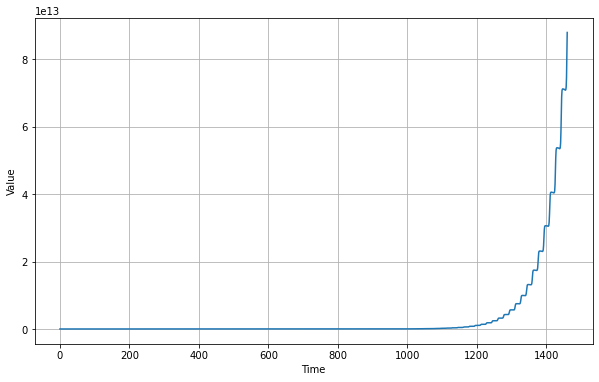

In [ ]:
#export
ac_series1 = autocorrelate1(times, 10, seed=42)
plot_series(times, ac_series1)

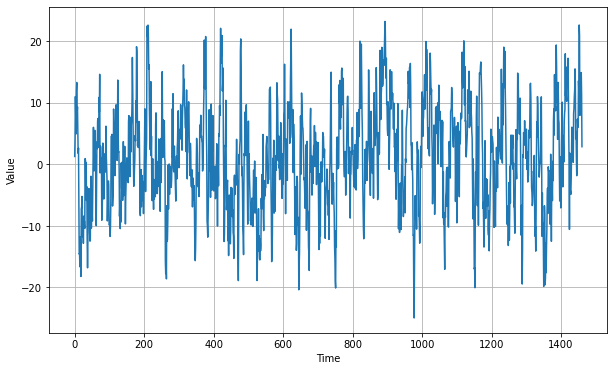

In [ ]:
#export
ac_series2 = autocorrelate2(times, 5, seed=42)
plot_series(times, ac_series2)

### Kết hợp Xu Thế, Vụ Mùa, Nhiễu, Autocorrelation

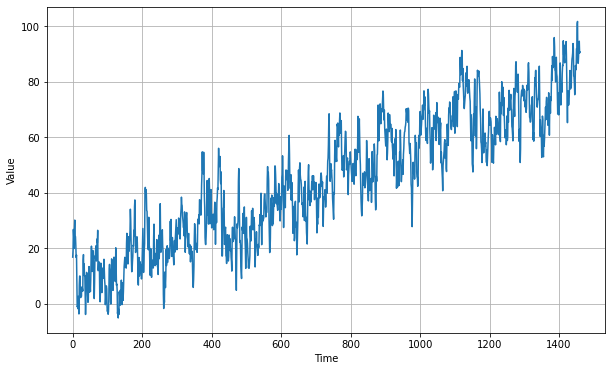

In [ ]:
#export
# Kết hợp lại:
tseries += ac_series2
plot_series(times, tseries)

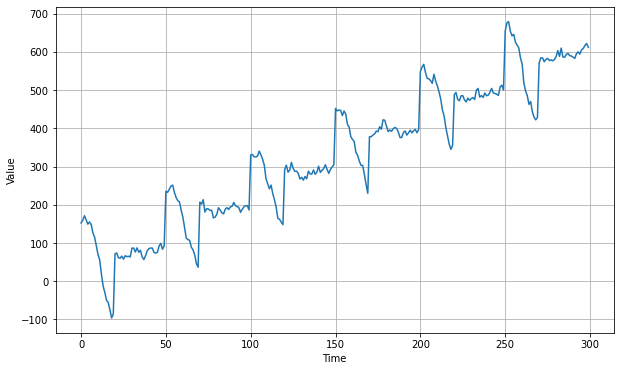

In [ ]:
#export
# Tạo mới series:
beta = 500
tseries1 = autocorrelate2(times, 10, seed=42) + create_seasonalities(times, period=50, amplitude=150) + create_trend(times, 2)
plot_series(times[:300], tseries1[:300])

# Kiểm tra dữ liệu
> Một trong các bước kiểm tra dữ liệu cơ bản nhất của time-series là tìm ra autocorrelate. Trong pandas, chúng ta có method autocorrelation_plot có thể được sử dụng để kiểm tra mức độ autocorrelate của timeseries: 

In [ ]:
#export
from pandas.plotting import autocorrelation_plot

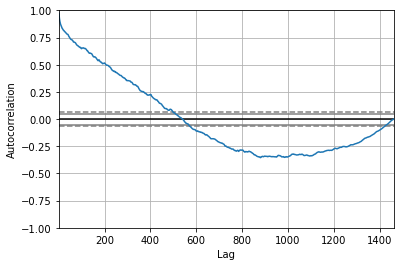

In [ ]:
#export
autocorrelation_plot(tseries)
plt.show()

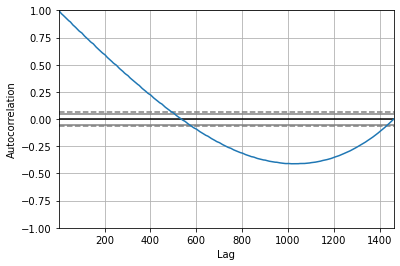

In [ ]:
#export
autocorrelation_plot(tseries1)
plt.show()

**NOTE:**
Chúng ta có thể thấy với cả 2 dữ liệu trên, mức độ autocorrelation là rất lớn ở nhiều ngưỡng lag khác nhau. Cao nhất là ở ngưỡng lag 1. Lý do là vì chúng ta đã sử dụng dữ liệu bao gồm autocorrelation với hệ số correlate là 0.8, ngoài ra, chúng ta cũng đã bổ sung cả xu thế + vụ mùa, khiến cho autocorrelation càng cao hơn.

# Sử dụng ARIMA
> Arima là viết tắt của autoregressive integrated moving average là một biến thể của ARMA (autogressive moving average), một model toán học được sử dụng để mô tả về dữ liệu dạng time-series sử dụng dữ liệu quá khứ để dự báo dữ liệu của tương lai. Khác với ARMA, sử dụng chính dữ liệu quá khứ, thì ARIMA sử dụng phần khác biệt (difference) giữa dữ liệu của các khoảng thời gian với nhau để tính sự khác biệt của các khoảng thời gian trong tương lại. Sau đó, để tính dữ liệu tương lại, chúng ta chỉ cần cộng phần khác biệt được dự đoán với dữ liệu hiện tại.

In [ ]:
#export
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(tseries, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4462.441
Method:                       css-mle   S.D. of innovations              5.142
Date:                Sat, 10 Jul 2021   AIC                           8938.882
Time:                        06:33:19   BIC                           8975.886
Sample:                             1   HQIC                          8952.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0493      0.096      0.516      0.606      -0.138       0.237
ar.L1.D.y      0.0435      0.026      1.666      0.096      -0.008       0.095
ar.L2.D.y     -0.2709      0.026    -10.439      0.0

Với mô hình arima, chúng ta có thể thấy ở lag = 2 (t-2), tỷ lệ coef là -.29 khá là cao, với giá trị z là -10.439, nhỏ hơn rất nhiều mức z ở 0.025 (-0.322), đồng nghĩa với việc mức độ significance của coefficient này là rất cao.

In [ ]:
#export
# Thử với số lượng lag <= 10
model1 = ARIMA(tseries, order=(10, 1, 1))
model_fit1 = model1.fit(disp=0)
print(model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                ARIMA(10, 1, 1)   Log Likelihood               -4423.103
Method:                       css-mle   S.D. of innovations              4.998
Date:                Sat, 10 Jul 2021   AIC                           8872.206
Time:                        06:33:42   BIC                           8940.927
Sample:                             1   HQIC                          8897.842
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0517      0.002     23.029      0.000       0.047       0.056
ar.L1.D.y      0.9883      0.026     37.763      0.000       0.937       1.040
ar.L2.D.y     -0.3176      0.037     -8.641      0.0

Ngoài ra, chúng ta cũng có thể tạo model sử dụng moving average. Về cơ bản, chúng ta dự đoán kết quả tương lại sử dụng nhiều dữ liệu trong quá khứ và lấy số bình quân (average) của dữ liệu trong quá khứ này (hoặc có thể nhân với hệ số) để làm kết quả cho tương lai.

In [ ]:
#export
def moving_average_model(series, lag=5, phi=1, seed=None):
    np.random.RandomSate(seed)
    for i in range(lag, len(series)+lag):
        series[i] = np.mean(sum(series[i-lag:i])) * phi
    return series[lag:]